In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
from glob import glob as glob
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gsname = 'gs1209'

### load data

In [3]:
## run make_df-1102.py to make dfs
datadf = datadf1 = pd.read_csv('data/%s-datadf-1.csv'%gsname)
datadf = datadf2 = pd.read_csv('data/%s-datadf-0.csv'%gsname)


In [4]:
gsdf = pd.read_csv('data/%s-summdf.csv'%gsname).astype(float)
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,testacc-b,acc2-b,testacc-e,acc2-e,testacc-i,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m
0,0.0,3.717295,16.222551,35.871727,0.228365,0.0,1.0,0.646055,0.982747,1.0,0.978312,0.948879,0.978311,0.948895,0.500630,0.476040,0.503326,0.475456,0.492804,0.858090
1,0.0,4.622216,9.881166,91.148061,0.067332,0.0,1.0,0.170778,0.993162,1.0,0.981537,0.955910,0.981536,0.955909,0.596194,0.323286,0.981369,0.322815,0.981481,0.942654
2,0.0,5.105998,93.902653,78.604957,0.245869,0.0,1.0,0.317960,0.979217,1.0,0.977147,0.947393,0.977133,0.947475,0.501976,0.472222,0.495440,0.471169,0.502094,0.868697
3,0.0,5.937128,41.509998,68.360499,0.618502,0.0,1.0,0.217177,0.993012,1.0,0.977340,0.935658,0.977346,0.935661,0.499893,0.488486,0.498884,0.487333,0.497993,0.795947
4,0.0,6.702755,6.462444,71.749209,0.236737,0.0,1.0,0.177301,0.973349,1.0,0.975830,0.940749,0.975814,0.940690,0.518318,0.351972,0.975638,0.355017,0.975809,0.931191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110336,0.0,52.640456,98.477054,39.898433,0.141220,0.0,1.0,0.346108,0.997649,1.0,0.981400,0.953854,0.981399,0.953852,0.654786,0.500000,0.981008,0.500000,0.981265,0.953858
110337,0.0,52.742868,57.311430,81.873366,0.859888,0.0,1.0,0.298237,0.997123,1.0,0.977847,0.928713,0.977857,0.928735,0.615321,0.500000,0.975273,0.500000,0.976973,0.928745
110338,0.0,53.339280,81.230007,40.704611,1.146425,0.0,1.0,0.829310,0.982117,1.0,0.959610,0.905815,0.959608,0.905909,0.598492,0.500000,0.957831,0.500000,0.959388,0.905780
110339,0.0,61.973294,81.286848,74.533465,1.032983,0.0,1.0,0.523612,0.974730,1.0,0.952217,0.903463,0.952230,0.903962,0.604517,0.500000,0.951320,0.500000,0.952288,0.903494


In [5]:
## human data
hdf = pd.read_csv('../human_data.csv')
humanD = {}
for c in ['blocked','interleaved','early','middle','late']:
  humanD[c[0]] = hdf.loc[:,('%s mean')%c].values.T[-40:].mean()
## difference to human
for c in ['b','i','e','m','l']:
  gsdf['%s-test_diff'%c] = np.abs(gsdf.loc[:,'testacc-%s'%c] - humanD[c])

In [6]:
# datadf.columns
# paramL = ['concentration', 'stickiness_wi', 'stickiness_bt',
#        'sparsity', 'pvar', 'lrate', 'lratep', 'decay_rate']

### compute df metrics, form summary df

In [7]:
# subset of dataframe containing relevant params
Btest = gsdf.loc[:,'testacc-b'] > 0.95
Itest1 = gsdf.loc[:,'testacc-i'] > 0.6
Itest2 = gsdf.loc[:,'testacc-i'] < 0.65
Etest = gsdf.loc[:,'testacc-e'] > 0.8
Mtest1 = gsdf.loc[:,'testacc-m'] > 0.8
Mtest2 = gsdf.loc[:,'testacc-m'] < 0.85
Ltest = gsdf.loc[:,'testacc-l'] > 0.6
Iblock2 = gsdf.loc[:,'acc2-i'] > 0.51
skipt1 = gsdf.loc[:,'skipt1'] == 0
MItest = gsdf.loc[:,'testacc-m'] - gsdf.loc[:,'testacc-i'] > 0.1
LItest = gsdf.loc[:,'testacc-l'] - gsdf.loc[:,'testacc-i'] > 0.1

C = Btest&Itest1&Itest2&skipt1
sgsdf = gsdf[C]
sgsdf = sgsdf.sort_values('testacc-l',ascending=False)
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
104625,0.0,12.875991,56.122991,37.820008,0.193591,0.0,1.0,0.073905,0.998410,0.0,...,0.5,0.980574,0.5,0.964356,0.939382,0.067743,0.013850,0.057707,0.274018,0.237800
29627,0.0,12.170542,71.146014,10.474346,0.246904,0.0,1.0,0.077581,0.997128,0.0,...,0.5,0.980030,0.5,0.980472,0.944027,0.063735,0.005449,0.072575,0.290135,0.237256
58905,0.0,12.409131,86.879919,10.972566,0.299155,0.0,1.0,0.112002,0.999182,0.0,...,0.5,0.980010,0.5,0.972726,0.946253,0.067471,0.009403,0.072744,0.282389,0.237235
84397,0.0,3.752534,74.445247,3.546766,0.307879,0.0,1.0,0.039152,0.998955,0.0,...,0.5,0.979960,0.5,0.980505,0.948541,0.067408,0.011326,0.072678,0.290167,0.237186
50691,0.0,7.956529,67.302471,16.158102,0.195019,0.0,1.0,0.070557,0.993351,0.0,...,0.5,0.979852,0.5,0.980162,0.949520,0.066902,0.009147,0.072180,0.289824,0.237078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,0.0,31.698567,95.520257,52.221072,0.629779,0.0,1.0,0.103274,0.996813,0.0,...,0.5,0.880009,0.5,0.912534,0.930631,0.038304,0.026681,0.019236,0.222197,0.137235
63322,0.0,21.396164,84.908827,24.123151,0.223275,0.0,1.0,0.075352,0.999786,0.0,...,0.5,0.879964,0.5,0.890985,0.934956,0.043792,0.013750,0.005799,0.200648,0.137189
102318,0.0,40.637042,91.264808,57.568576,0.563838,0.0,1.0,0.150078,0.998129,0.0,...,0.5,0.874716,0.5,0.884509,0.915212,0.048148,0.035824,0.060908,0.194172,0.131942
15272,0.0,18.344246,52.442949,23.359840,0.427997,0.0,1.0,0.065491,0.993858,0.0,...,0.5,0.874697,0.5,0.905385,0.927570,0.043709,0.040392,0.040537,0.215048,0.131923


In [8]:
## subset of df by difference from human
# Bd = gsdf.loc[:,'b-test_diff'] < 0.1
# Btest = gsdf.loc[:,'testacc-b'] > 0.85
Id = gsdf.loc[:,'i-test_diff'] < 0.1
Ed = gsdf.loc[:,'e-test_diff'] < 0.05
Md = gsdf.loc[:,'m-test_diff'] < 0.05
Ld = gsdf.loc[:,'l-test_diff'] < 0.05
# Etest = gsdf.loc[:,'testacc-b'] > 0.85

C = Md&Ld
sgsdf = gsdf[C]
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
6851,0.0,35.548728,82.888183,82.387461,0.431140,0.0,1.0,0.190504,0.975972,0.0,...,0.459627,0.697478,0.462257,0.707248,0.882999,0.032242,0.141707,0.010454,0.016911,0.045297
10090,0.0,6.082809,87.546674,72.792090,0.054323,0.0,1.0,0.175965,0.972213,0.0,...,0.494718,0.704776,0.476556,0.712783,0.893709,0.044394,0.113456,0.023303,0.022445,0.037998
11262,0.0,2.690934,2.881755,56.559874,1.075823,0.0,1.0,0.022991,0.983860,1.0,...,0.396933,0.725267,0.395692,0.725577,0.900775,0.061671,0.132891,0.174772,0.035240,0.017507
13679,0.0,41.492307,61.571884,95.356466,0.693505,0.0,1.0,0.180511,0.985950,1.0,...,0.375121,0.790279,0.374021,0.739888,0.917379,0.058880,0.109126,0.064131,0.049550,0.047505
14909,0.0,45.363432,63.362861,89.314465,0.608274,0.0,1.0,0.199324,0.974122,1.0,...,0.368501,0.746460,0.367180,0.696643,0.914505,0.051757,0.095873,0.057081,0.006306,0.003686
15541,0.0,23.311455,82.343376,98.858717,0.210826,0.0,1.0,0.176673,0.981495,0.0,...,0.467508,0.699219,0.470684,0.729296,0.889013,0.019190,0.149715,0.009301,0.038959,0.043555
23302,0.0,38.972119,43.908222,90.891910,0.674912,0.0,1.0,0.166963,0.995716,1.0,...,0.373139,0.744541,0.373225,0.709020,0.922845,0.064774,0.091815,0.070056,0.018683,0.001767
36092,0.0,33.239492,76.244161,79.532449,0.408478,0.0,1.0,0.201788,0.977646,0.0,...,0.462488,0.696923,0.468915,0.716018,0.883648,0.016762,0.142050,0.010527,0.025681,0.045851
38702,0.0,3.161891,46.245333,49.411563,0.046681,0.0,1.0,0.142832,0.987578,1.0,...,0.465929,0.734218,0.463907,0.685733,0.856219,0.068075,0.138953,0.073350,0.004604,0.008556
43258,0.0,24.948846,25.292633,77.053599,0.317801,0.0,1.0,0.105940,0.984452,1.0,...,0.344080,0.763841,0.343662,0.712659,0.932350,0.063912,0.085135,0.069167,0.022321,0.021066


### plt single condition

In [9]:
def get_cond_df(row):
  ## form query string for above row
  query_str = " and ".join(
    ["%s == %f"%(k,v) for k,v in dict(row.astype(float)[1:10].round(4)).items()]
  )
  print('query',query_str)
  ## df of single parameter condition`
  cond_df = datadf1.round(4).query(query_str)
  if not len(cond_df):
    cond_df = datadf2.round(4).query(query_str)
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  print('found',paramstr)
  return cond_df


In [10]:
def plt_cond_df(cond_df):
  f,axar = plt.subplots(1,1,figsize=(20,8))
  ax=axar
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  for c,cdf in cond_df.groupby('cond'):
    try:
#       if c not in ['blocked','interleaved']:
#         print('FIGURES WITH BI ONLY')
#         continue
      ax.plot(np.arange(200),cdf.acc,label=c)
    except:
      print('err',paramstr,c)
      continue
  ax.set_ylim(0,1)
  plt.legend()
  plt.axhline(0.5,c='k',ls='--')
  
  plt.title("%s\n%s"%(paramstr[:94],paramstr[94:]))
  plt.savefig('figures/analysis_gs/acc-%s.png'%paramstr)


In [11]:
## select single param for plotting full acc trace
row = sgsdf.sort_values('testacc-l',ascending=False).iloc[0]
print(row.astype(float))
cond_df = get_cond_df(row)

Unnamed: 0        0.000000
concentration    41.492307
stickiness_wi    61.571884
stickiness_bt    95.356466
sparsity          0.693505
pvar              0.000000
lrate             1.000000
lratep            0.180511
decay_rate        0.985950
skipt1            1.000000
testacc-b         0.972289
acc2-b            0.929136
testacc-e         0.972263
acc2-e            0.929179
testacc-i         0.540062
acc2-i            0.375121
testacc-l         0.790279
acc2-l            0.374021
testacc-m         0.739888
acc2-m            0.917379
b-test_diff       0.058880
i-test_diff       0.109126
e-test_diff       0.064131
m-test_diff       0.049550
l-test_diff       0.047505
Name: 13679, dtype: float64
query concentration == 41.492300 and stickiness_wi == 61.571900 and stickiness_bt == 95.356500 and sparsity == 0.693500 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.180500 and decay_rate == 0.985900 and skipt1 == 1.000000
found concentration-41.4923__stickiness_wi-61.5719__stickines

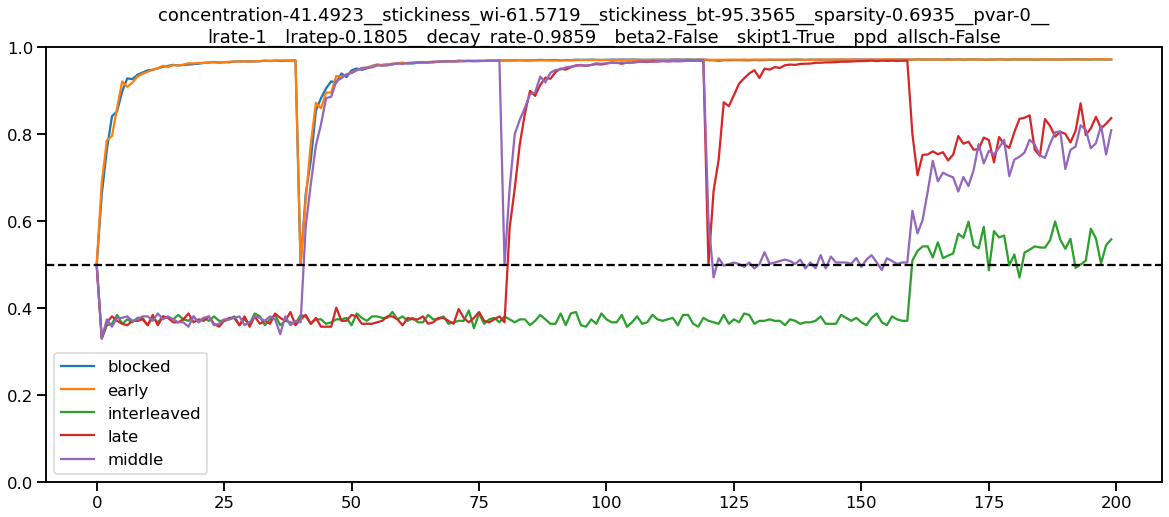

In [12]:
plt_cond_df(cond_df)

### plot full subtable

In [13]:
for idx,row in sgsdf.iterrows():
  print()
  cond_df = get_cond_df(row)
  plt_cond_df(cond_df)
  plt.close('all')


query concentration == 35.548700 and stickiness_wi == 82.888200 and stickiness_bt == 82.387500 and sparsity == 0.431100 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.190500 and decay_rate == 0.976000 and skipt1 == 0.000000
found concentration-35.5487__stickiness_wi-82.8882__stickiness_bt-82.3875__sparsity-0.4311__pvar-0__lrate-1__lratep-0.1905__decay_rate-0.976__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 6.082800 and stickiness_wi == 87.546700 and stickiness_bt == 72.792100 and sparsity == 0.054300 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.176000 and decay_rate == 0.972200 and skipt1 == 0.000000
found concentration-6.0828__stickiness_wi-87.5467__stickiness_bt-72.7921__sparsity-0.0543__pvar-0__lrate-1__lratep-0.176__decay_rate-0.9722__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 2.690900 and stickiness_wi == 2.881800 and stickiness_bt == 56.559900 and sparsity == 1.075800 and pvar == 0.000000 and lrate == 1.0

found concentration-19.1875__stickiness_wi-37.1592__stickiness_bt-83.2972__sparsity-0.6387__pvar-0__lrate-1__lratep-0.0763__decay_rate-0.9803__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 23.725700 and stickiness_wi == 26.283200 and stickiness_bt == 51.379800 and sparsity == 1.032900 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.105300 and decay_rate == 0.987800 and skipt1 == 1.000000
found concentration-23.7257__stickiness_wi-26.2832__stickiness_bt-51.3798__sparsity-1.0329__pvar-0__lrate-1__lratep-0.1053__decay_rate-0.9878__beta2-False__skipt1-True__ppd_allsch-False

query concentration == 13.585500 and stickiness_wi == 68.984300 and stickiness_bt == 96.514300 and sparsity == 0.117400 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.561800 and decay_rate == 0.977600 and skipt1 == 1.000000
found concentration-13.5855__stickiness_wi-68.9843__stickiness_bt-96.5143__sparsity-0.1174__pvar-0__lrate-1__lratep-0.5618__decay_rate-0.9776__beta2-Fals

In [14]:
np.arange(200)[40:80]

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79])